### Import the Libraries

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

2024-04-15 00:27:13.305437: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 00:27:13.356808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 00:27:14.377546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/saad-bscs/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a 

### Constants

In [2]:
batch_size = 32
num_classes = 124
tf.random.set_seed(42)
img_height, img_width = 128, 128
data_dir = os.path.join(os.getcwd(), "../5-Gait-Energy-Images")

### Training Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rescale=1.0 / 255,
    rotation_range=20,
    fill_mode="nearest",
    horizontal_flip=True,
    zoom_range=[0.8, 1.2],
    width_shift_range=0.2,
    validation_split=0.15,
    height_shift_range=0.2,
    channel_shift_range=10,
    brightness_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [4]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and Split Data into Training and Testing Sets

In [5]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=True,
    subset="training",
    batch_size=batch_size,
    class_mode="categorical",
    target_size=(img_height, img_width),
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=False,
    subset="validation",
    batch_size=batch_size,
    class_mode="categorical",
    target_size=(img_height, img_width),
)

Found 11587 images belonging to 124 classes.
Found 1974 images belonging to 124 classes.


### Load Pre-Trained EfficientNetB7 without Top Layers

In [6]:
base_model = EfficientNetB7(
    weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3)
)

2024-04-15 00:27:16.778333: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Add custom classification layers

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
predictions = Dense(num_classes, activation='linear',
                    kernel_regularizer=l2(0.003))(x)

### Create the model

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

### Fine Tune the layers

In [9]:
for layer in model.layers:
    layer.trainable = True

### Define Top k Accuracy Function

In [10]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Compile the model

In [11]:
model.compile(
    optimizer=RMSprop(
        rho=0.9,
        momentum=0.0,
        epsilon=1e-07,
        name="RMSprop",
        centered=False,
        learning_rate=1e-4,
    ),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["acc", top_5_accuracy],
)

### Define the Callbacks

In [12]:
checkpoint = ModelCheckpoint(
    "best_model.h5", monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_acc', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.1, patience=5, min_lr=1e-7)

### Train the model

In [13]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=500,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    use_multiprocessing=True)

Epoch 1/500
363/363 [==============================] - ETA: 0s - loss: 13.1295 - acc: 0.0129 - top_5_accuracy: 0.0608

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


363/363 [==============================] - 909s 2s/step - loss: 13.1295 - acc: 0.0129 - top_5_accuracy: 0.0608 - val_loss: 12.6121 - val_acc: 0.0076 - val_top_5_accuracy: 0.0380 - lr: 1.0000e-04
Epoch 2/500
363/363 [==============================] - 858s 2s/step - loss: 12.0419 - acc: 0.0476 - top_5_accuracy: 0.1612 - val_loss: 12.1538 - val_acc: 0.0162 - val_top_5_accuracy: 0.0593 - lr: 1.0000e-04
Epoch 3/500
363/363 [==============================] - 855s 2s/step - loss: 10.8454 - acc: 0.1218 - top_5_accuracy: 0.3394 - val_loss: 10.4871 - val_acc: 0.1231 - val_top_5_accuracy: 0.3749 - lr: 1.0000e-04
Epoch 4/500
363/363 [==============================] - 858s 2s/step - loss: 9.7631 - acc: 0.2166 - top_5_accuracy: 0.5050 - val_loss: 9.9583 - val_acc: 0.1793 - val_top_5_accuracy: 0.4174 - lr: 1.0000e-04
Epoch 5/500
363/363 [==============================] - 855s 2s/step - loss: 8.7059 - acc: 0.3483 - top_5_accuracy: 0.6633 - val_loss: 9.3966 - val_acc: 0.1859 - val_top_5_accuracy: 0.464

### Evaluate Model on Training Set

In [14]:
train_loss, train_accuracy, top5train = model.evaluate(train_generator)
print(f"Training Loss: {round(train_loss, 2)}")
print(f"Training Accuracy: {round(train_accuracy, 2)}")
print(f"Training Top 5 Accuracy: {round(top5train, 2)}")

363/363 [==============================] - 190s 522ms/step - loss: 1.8663 - acc: 0.9921 - top_5_accuracy: 0.9995
Training Loss: 1.87
Training Accuracy: 0.99
Training Top 5 Accuracy: 1.0


### Evaluate Model on Testing Set

In [15]:
test_loss, test_accuracy, top5test = model.evaluate(test_generator)
print(f"Testing Loss: {round(test_loss, 2)}")
print(f"Testing Accuracy: {round(test_accuracy, 2)}")
print(f"Testing Top 5 Accuracy: {round(top5test, 2)}")

62/62 [==============================] - 33s 524ms/step - loss: 2.3411 - acc: 0.8698 - top_5_accuracy: 0.9732
Testing Loss: 2.34
Testing Accuracy: 0.87
Testing Top 5 Accuracy: 0.97


### Save the Model

In [16]:
model.save('../9-Trained-Fine-Tune-Models/EfficientNetB7.h5')

### Model Summary

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 128, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 128, 128, 3)          0         ['normalization[0][0]']   

### Plot Training & Validation Accuracy

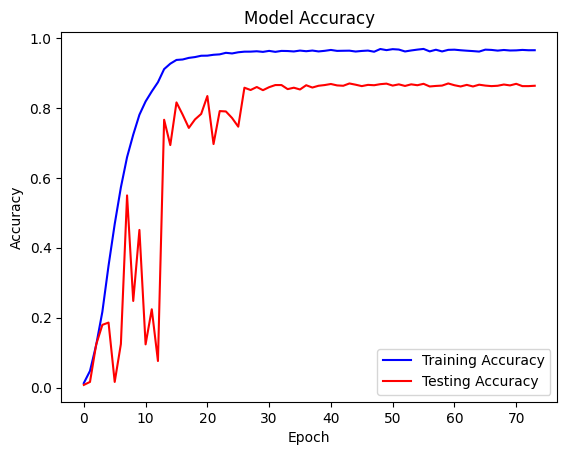

In [18]:
plt.plot(history.history['acc'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_acc'],
         color='red', label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

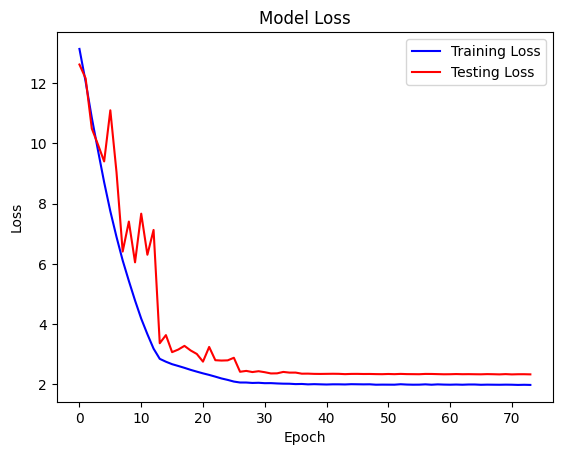

In [19]:
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Testing Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Training and Testing Top 5 Accuracy

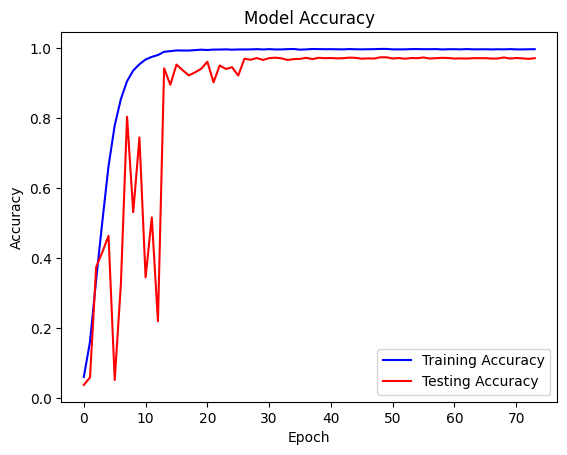

In [20]:
plt.plot(history.history['top_5_accuracy'],
         color='blue', label='Training Accuracy')
plt.plot(history.history['val_top_5_accuracy'],
         color='red', label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()